# Data Prep / Setup

In [17]:
!pip install plotnine


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
import collections
import plotnine
from plotnine import *
from xgboost import XGBRegressor
import os
import ast
import random
import pickle

In [50]:
modeling_filtered_path = "../tmp/filtered_sep_01_dataset.csv"
modeling_dataset = pd.read_csv(modeling_filtered_path)

In [51]:
def load_and_predict(id_num, dataset, model_storage_path): 
    model_filename = os.path.join(model_storage_path, "model_id" + str(id_num) + ".pkl")
    if_model = pickle.load(open(model_filename, 'rb'))
    
    #results = if_model.predict(dataset)
    results = if_model.score_samples(dataset) * -1
    
    return results

In [52]:
final_params = {
    'alpha': 2,
    'eta': 0.1,
    'gamma': 2,
    'max_depth': 5,
    'min_child_weight': 8,
    'subsample': 0.8999999999999999}

model = XGBRegressor(**final_params)
X, y = modeling_dataset[['year', 'quarter', 'lag1']], modeling_dataset[['score']]
model.fit(X, y)
xgb_predicted_score = model.predict(X)
xgb_outlier_prediction = (abs(y['score'] - xgb_predicted_score) > 15)
xgb_modeling_dataset = modeling_dataset.copy()[['score', 'lag1','y_quarter','providerId']]
xgb_modeling_dataset['outlier'] = xgb_outlier_prediction
xgb_modeling_dataset['lag1_diff'] = xgb_modeling_dataset['score'] - xgb_modeling_dataset['lag1']
xgb_modeling_dataset['model'] = "XGBoost Regression"

In [53]:
model_storage_path = './isolation_forest/candidate_models/run_2022-10-28-02h31m/'
if_outlier_prediction = load_and_predict(36, modeling_dataset.drop(columns = ['y_quarter', 'providerId', 'lag1']), model_storage_path)
if_modeling_dataset = modeling_dataset.copy()[['score', 'lag1','y_quarter','providerId']]
if_modeling_dataset['outlier'] = if_outlier_prediction > 0.59
if_modeling_dataset['lag1_diff'] = if_modeling_dataset['score'] - if_modeling_dataset['lag1']
if_modeling_dataset['model'] = "Isolation Forest"

In [54]:
comparison_df = pd.concat([xgb_modeling_dataset, if_modeling_dataset], axis = 0)

In [55]:
xgb_modeling_dataset['predicted_score'] = xgb_predicted_score

In [56]:
provider_means = (
    modeling_dataset
    .groupby('providerId')['score']
    .mean()
    .reset_index()
    .rename(columns = {'score':'provider_mean_score'})
)
provider_means
comparison_df = comparison_df.merge(provider_means,
                                    how = 'left', 
                                    on = 'providerId')

In [57]:
comparison_df

,score,lag1,y_quarter,providerId,outlier,lag1_diff,model,provider_mean_score
0,62,62.0,2017Q3,10001,False,0.0,XGBoost Regression,59.142857
1,61,62.0,2017Q4,10001,False,-1.0,XGBoost Regression,59.142857
2,60,61.0,2018Q1,10001,False,-1.0,XGBoost Regression,59.142857
3,61,60.0,2018Q2,10001,False,1.0,XGBoost Regression,59.142857
4,62,61.0,2018Q3,10001,False,1.0,XGBoost Regression,59.142857
...,...,...,...,...,...,...,...,...
84585,66,72.0,2021Q3,670128,False,-6.0,Isolation Forest,79.500000
84586,91,91.0,2020Q3,670131,True,0.0,Isolation Forest,83.500000
84587,87,91.0,2020Q4,670131,True,-4.0,Isolation Forest,83.500000
84588,86,87.0,2021Q1,670131,True,-1.0,Isolation Forest,83.500000


# XGBoost Regression Model

#### RMSE and MAE (lower is better)

In [38]:
rmse = np.sqrt(np.mean((xgb_modeling_dataset['score'] - xgb_modeling_dataset['predicted_score'])**2))
mae = np.sqrt(np.mean(abs(xgb_modeling_dataset['score'] - xgb_modeling_dataset['predicted_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,5.443164,1.920621


# Isolation Forest Model

# Model Comparisons

In [63]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier            False                                True  \
Model             Isolation Forest XGBoost Regression Isolation Forest   
Score count                39945.0            41386.0           2350.0   
      mean                    56.2               55.7             45.6   
      std                     16.0               18.1             38.7   
      min                      0.0                0.0              0.0   
      10%                     34.0               32.0              6.0   
      25%                     45.0               44.0             14.0   
      50%                     57.0               57.0             21.0   
      75%                     68.0               69.0             90.0   
      90%                     78.0               79.0             95.0   
      max                    100.0              100.0            100.0   

Predicted Outlier                     
Model             XGBoost Regression  
Score count                    909.0  
      mean                      52.7  
      std                       21.2  
      min                        0.0  
      10%                       26.0  
      25%                       37.0  
      50%                       53.0  
      75%                       70.0  
      90%                       82.0  
      max                      100.0

#### XGBoost Outlier Counts by Quarter

In [72]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2017Q3,NaN,3001,NaN
2017Q4,7.0,3067,0.23
2018Q1,21.0,3069,0.68
2018Q2,22.0,3069,0.72
2018Q3,21.0,3084,0.68
2018Q4,28.0,3086,0.91
2019Q1,29.0,3074,0.94
2019Q2,21.0,3079,0.68
2019Q3,30.0,3082,0.97
2019Q4,21.0,3069,0.68


#### Isolation Forest Outlier Counts by Quarter

In [73]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2017Q3,249,3001,8.30
2017Q4,382,3067,12.46
2018Q1,228,3069,7.43
2018Q2,159,3069,5.18
2018Q3,94,3084,3.05
2018Q4,132,3086,4.28
2019Q1,134,3074,4.36
2019Q2,117,3079,3.80
2019Q3,79,3082,2.56
2019Q4,115,3069,3.75


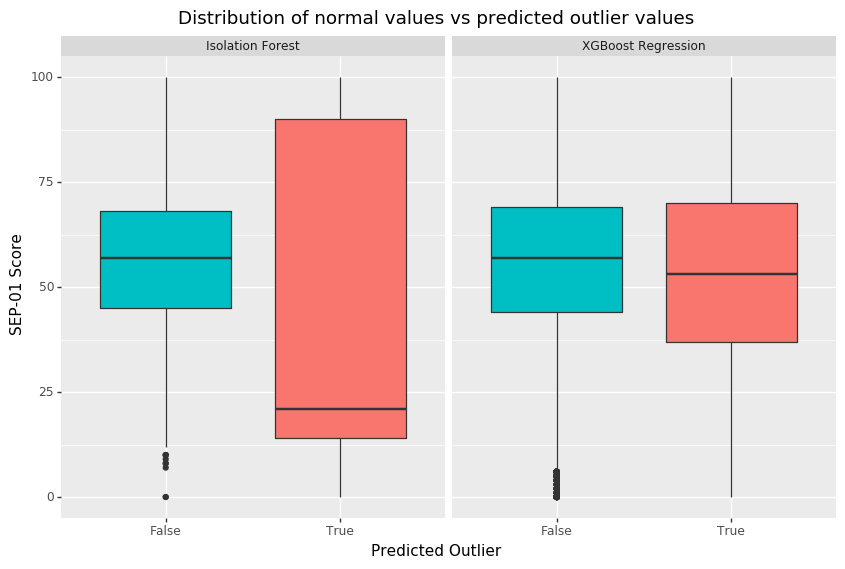

<ggplot: (8747297978093)>

In [43]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df,     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted outlier values")
 + ylab("SEP-01 Score")
 + xlab("Predicted Outlier")
 + labs(fill = 'Predicted Outlier')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model')
)

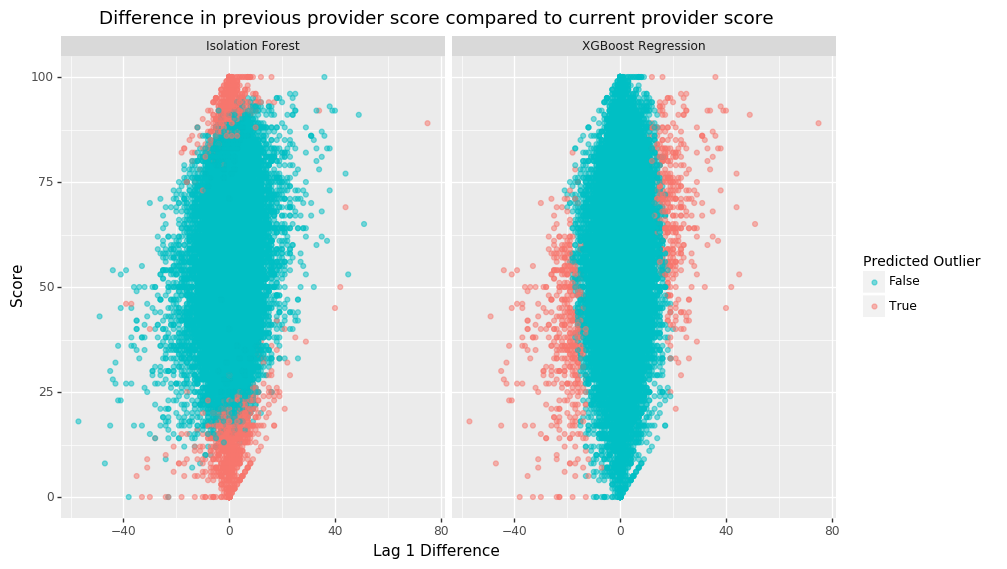

<ggplot: (8747298349429)>

In [42]:
(ggplot(comparison_df,     
        aes(x = 'lag1_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in previous provider score compared to current provider score")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.5)
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

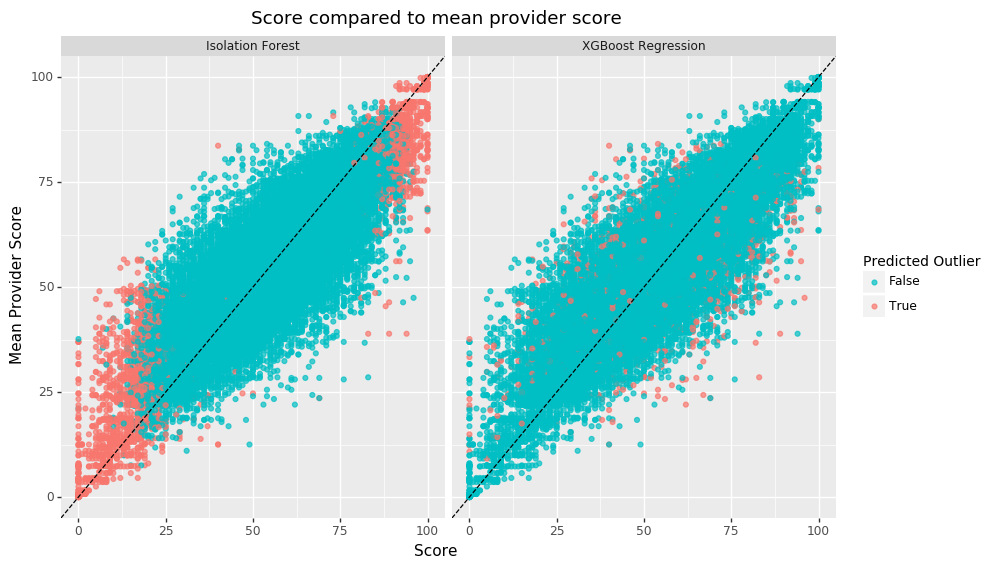

<ggplot: (8747298372633)>

In [44]:
(ggplot(comparison_df,
        aes(x = 'score',
            y = 'provider_mean_score',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score")
 + geom_point(size = 1.5, alpha = 0.7)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

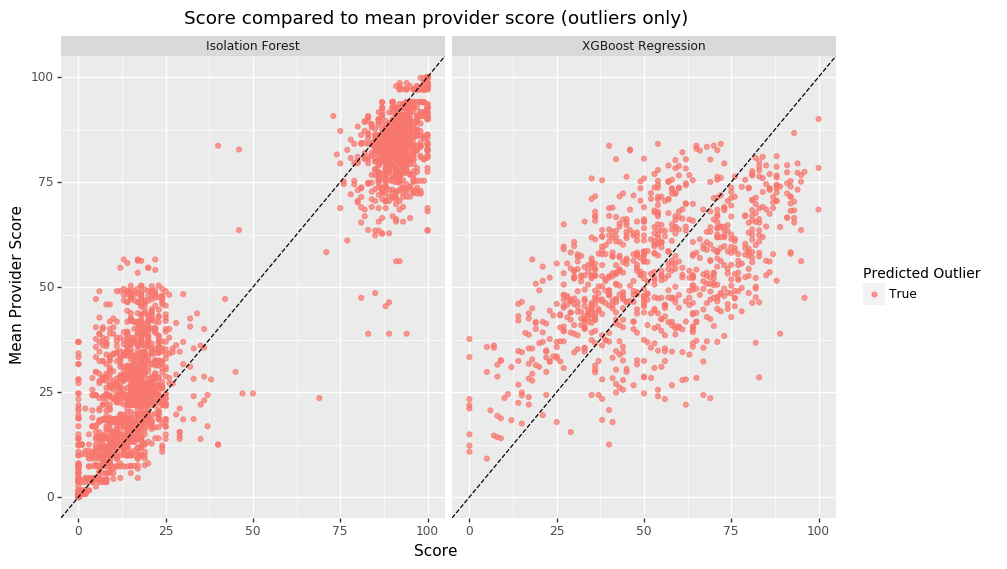

<ggplot: (8747298553353)>

In [45]:
(ggplot(comparison_df[comparison_df['outlier'] == True],
        aes(x = 'score',
            y = 'provider_mean_score',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (outliers only)")
 + geom_point(size = 1.5, alpha = 0.7)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

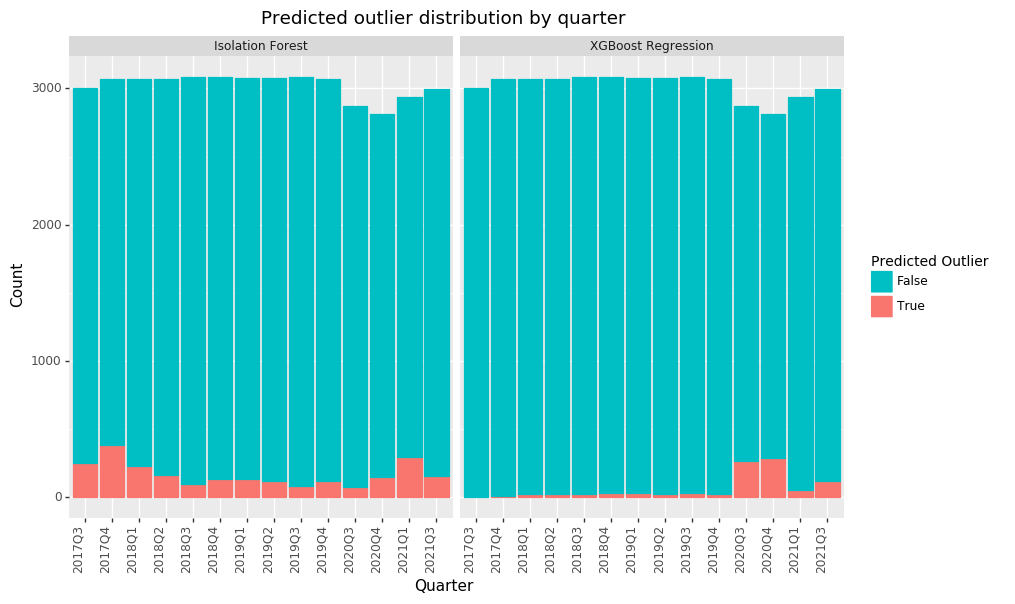

<ggplot: (8747298369869)>

In [46]:
(ggplot(comparison_df,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted outlier distribution by quarter")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)